In [11]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from data_loader import get_merged_scores_df
from plots_helper import *

In [12]:
df = get_merged_scores_df("popu_freq", home_dir)
df = df[(df["class"]!="Singleton")]
df["class"].value_counts()

Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'class', 'chrom', 'sift',
       'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'cadd_raw',
       'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate',
       'bStatistic', 'n_methods_having_preds', 'esm1b_t33_650M_UR50S',
       'esm1v_t33_650M_UR90S', 'esm2_t33_650M_UR50D', 'prottrans_bert_bfd',
       'prottrans_t5_xl_u50', 'vespa', 'proteinbert', 'sequnet', 'protbert',
       'unirep', 'conservation'],
      dtype='object')
(26409, 37)
Common        6976
Ultra-rare    6957
Singleton     6955
Rare          5521
Name: class, dtype: int64


Common        6976
Ultra-rare    6957
Rare          5521
Name: class, dtype: int64

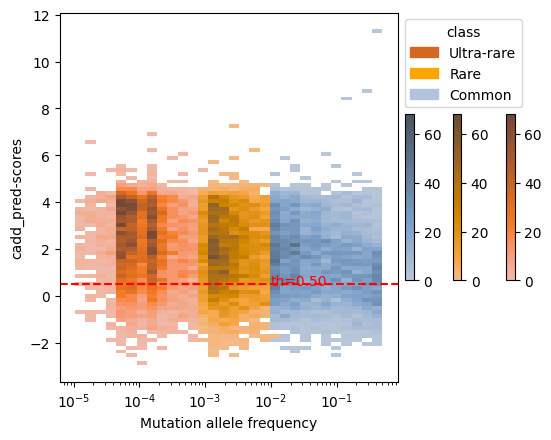

In [16]:
# this is a test for a single method cadd-raw
plt.clf()
ax = sns.histplot(data=df, x="mt_freq", y="cadd_raw", hue="class", log_scale=(True, False), cbar=True, cbar_kws=dict(fraction=.1, shrink=.45, pad=.02), palette=popu_freq_colors_dict, hue_order=popu_freq_class_order_wo_singleton)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=.5, color='r', linestyle='dashed')
plt.text(0.01, .5-.05, f"th={.5:.2f}", c="r")
plt.ylabel("cadd_pred-scores")
plt.xlabel("Mutation allele frequency")

plt.show()

	 1.0 1.0
	 0.77 0.9905300137467542
	 0.52 0.995269495412844
	 1.0 1.0
	 1.0 1.0
	 0.76 0.9903956422018348
	 0.98 0.9900758902510216
	 0.37999999999999945 0.9903832352519019
	 0.11999999999999922 0.9913990825688074
	 0.23999999999999932 0.9915424311926605
	 0.26999999999999935 0.9902522935779816
	 0.18999999999999928 0.991829128440367
	 0.2099999999999993 0.9922591743119266
	 0.11999999999999922 0.9913990825688074
	 0.2 0.9908256880733946
	 0.22 0.9909690366972477


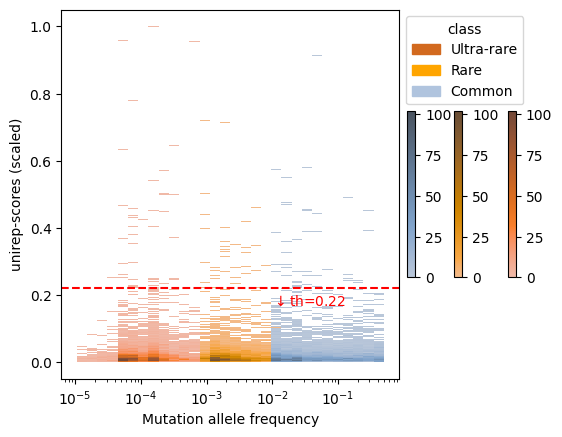

In [17]:
def do_hist_plot(df, method_name):
    ax = sns.histplot(data=df, x="mt_freq", y="pred", hue="class", log_scale=(True, False), cbar=True, cbar_kws=dict(fraction=.1, shrink=.45, pad=.02), palette=popu_freq_colors_dict, hue_order=popu_freq_class_order_wo_singleton)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xlabel("Mutation allele frequency")
    plt.ylabel(f"{method_name}-scores (scaled)")


def find_and_plot_th(df, method_name): # finding a th such that >99% of the common variants are correctly classified
    df.loc[df["class"]=="Common", "class_numeric"] = 1
    df.loc[df["class"]!="Common", "class_numeric"] = 0

    best_th = 0.0
    if method_name in all_methods_smaller_means_damaging: 
        ths = np.arange(1.1, 0, -.01)
        pos_class_numeric_assigned, neg_class_numeric_assigned = 1, 0
        direction = r'$\uparrow$'
    else: 
        ths = np.arange(0, 1.1, .01)
        pos_class_numeric_assigned, neg_class_numeric_assigned = 0, 1
        direction = r'$\downarrow$'


    for th in ths:
        df.loc[df["pred"]<=th, "class_numeric_assigned"] = neg_class_numeric_assigned
        df.loc[df["pred"]>th, "class_numeric_assigned"] = pos_class_numeric_assigned

        temp_df = df[df["class"]=="Common"]
        n_rows_annotated_as_common = temp_df[temp_df["class_numeric"]==temp_df["class_numeric_assigned"]]
        percentage = n_rows_annotated_as_common.shape[0]/temp_df.shape[0]
        if percentage >= .99:
            print("\t", th, percentage)
            best_th = th
            break
    
    if method_name in all_methods_smaller_means_damaging: best_th_yaxis_pos = best_th+.02
    else: best_th_yaxis_pos = best_th-.05
    
    plt.axhline(y=best_th, color='r', linestyle='dashed')
    plt.text(0.01, best_th_yaxis_pos, f"{direction}th={best_th:.2f}", c="r")


for i, method_name in enumerate(method_names):
    plt.clf()
    # method_name = "esm1b_t33_650M_UR50S"
    if method_name=="conservation": continue
    if method_name=="random_classifier": df[method_name] = [random.uniform(0, 1) for i in range(df.shape[0])]
    
    non_nan_df = df[~pd.isna(df[method_name])].copy()  # taking df for only non-NAN values
    non_nan_df["pred"]=(non_nan_df[method_name]-non_nan_df[method_name].min())/(non_nan_df[method_name].max()-non_nan_df[method_name].min()) # scaling prediction scores between [0, 1]
    
    find_and_plot_th(non_nan_df, method_name)
    do_hist_plot(non_nan_df, method_name)
    
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/plots_mut_allele_freq_vs_scores_histogram/{method_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)
    # break